In [74]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
!pip install cartopy
import cartopy.crs as ccrs

In [75]:
# read netCDF data into Dataset
era5 = xr.open_dataset("/content/drive/MyDrive/Colab Notebooks/Atmos_Dynamics/era5_aug2022.nc")

# z = geopotential height, t = temp, and u = zonal wind
era5

<xarray.Dataset> Size: 37MB
Dimensions:         (pressure_level: 3, latitude: 721, longitude: 1440)
Coordinates:
    number          int64 8B ...
    date            int64 8B ...
  * pressure_level  (pressure_level) float64 24B 150.0 100.0 70.0
  * latitude        (latitude) float64 6kB 90.0 89.75 89.5 ... -89.75 -90.0
  * longitude       (longitude) float64 12kB 0.0 0.25 0.5 ... 359.2 359.5 359.8
    expver          <U4 16B ...
Data variables:
    z               (pressure_level, latitude, longitude) float32 12MB ...
    t               (pressure_level, latitude, longitude) float32 12MB ...
    u               (pressure_level, latitude, longitude) float32 12MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-09-24T22:44 GRIB to CDM+CF via cfgrib-0.9.1...

In [ ]:
# constants and isolating temp data
temp = era5.t.sel(pressure_level=100)
P = 100*(10**2) # Pa
Rd = 287 # J/kg/K
omega = 7.3e-5 # rad/s
Re = 6.4e6 # m
dy = np.radians(0.25) * Re # degree

* To get dx by longitude, note arc distance of 0.25 degree longitude changes as we move from eq to poles.
* We get out an array of length 721 (number of latitude values)
* We need an array of length 1400 (number of longitude values)
* Arc distance will be the same for every longitude at some latitude

In [ ]:
# get f and dx for every latitude, but match shape to other data
lat_len = 721
long_len = 1440
f = np.ones((lat_len, long_len)) # initialize empty array for f
for i in range(lat_len):
    f_buf = 2*omega*np.sin(np.radians(temp.latitude[i]))

    # get rid of zeros to avoid infinity in ug
    if f_buf == 0:
      f_buf = 2*omega*np.sin(np.radians(0.25)) # set to value at 0.25 degree

    f[i, :] = f_buf

In [ ]:
# get dT_dx:
dT = -np.gradient(temp, axis=0)
dT_dy = np.divide(dT, dy)

In [ ]:
dvg_dp = -(Rd/(f*P))*dT_dy # vertical sheer of zonal thermal wind
dvg_dp_array = xr.DataArray(dvg_dp, coords=[temp.latitude, temp.longitude], dims=['latitude', 'longitude'])

In [ ]:
actual = (era5.u.sel(pressure_level=150) - era5.u.sel(pressure_level=70))/(150e2-70e2)

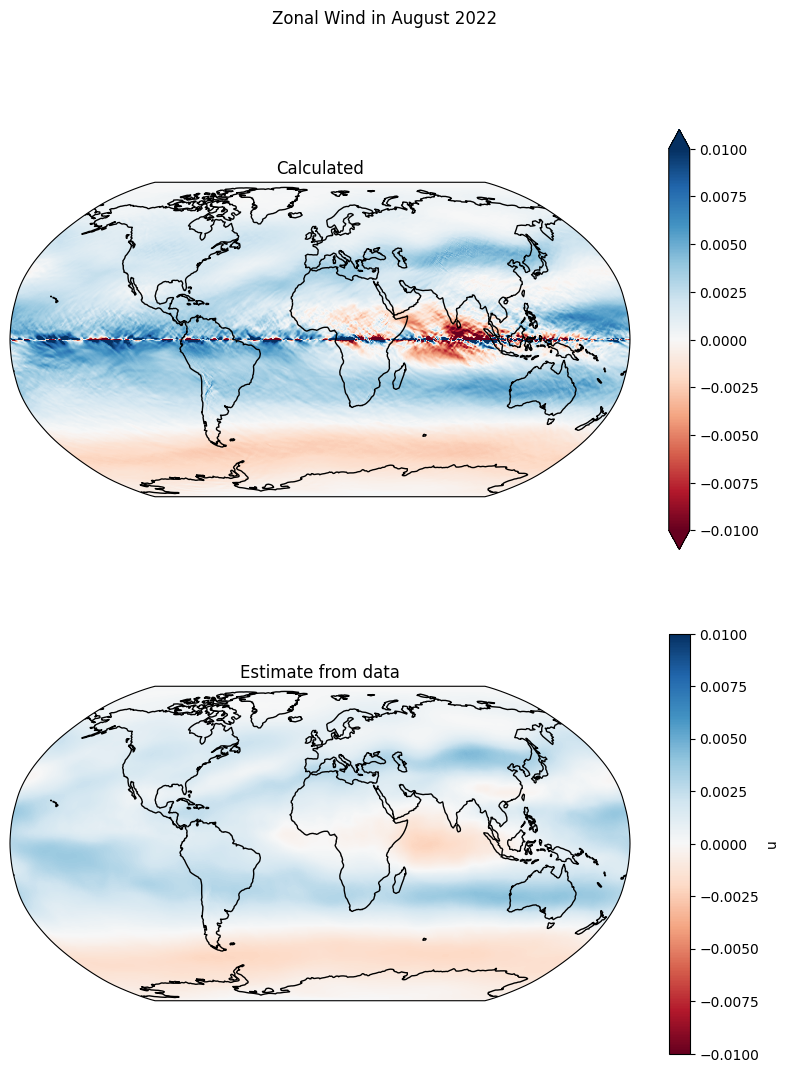

In [ ]:
# plot
fig, ax = plt.subplots(2, 1, figsize=(10, 12), subplot_kw=dict(projection=ccrs.Robinson()))
dvg_dp_array.plot(ax=ax[0], transform=ccrs.PlateCarree(), vmin=-1e-2, vmax=1e-2, cmap='RdBu')
actual.plot(ax=ax[1], transform=ccrs.PlateCarree(), vmin=-1e-2, vmax=1e-2, cmap='RdBu')
ax[0].coastlines()
ax[1].coastlines()
fig.suptitle('Zonal Wind in August 2022');
ax[0].set_title('Calculated');
ax[1].set_title('Estimate from data');

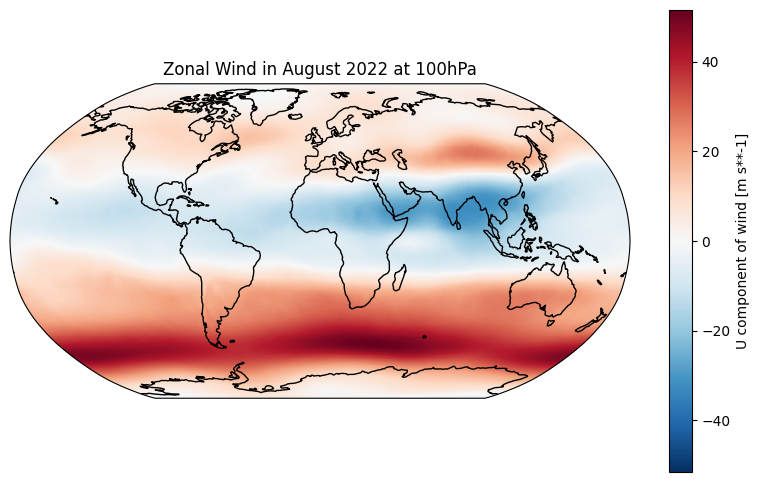

In [79]:
# plot zonal wind around 45 degrees South
fig, ax = plt.subplots(1, 1, figsize=(10, 6), subplot_kw=dict(projection=ccrs.Robinson()))
u1 = era5.u.sel(pressure_level=100.0)
u1.plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-180, 180, -90, 90])
ax.set_title('Zonal Wind in August 2022 at 100hPa');

In [82]:
era5.u.sel(pressure_level=100.0)

8.3504505